In [1]:
import torch
import torch.nn.functional as F

import json
import numpy as np
from matplotlib import cm

from captum.attr import IntegratedGradients


import sys
sys.path.append('../')

from evaluate_script import predict
from resnet import ResNet1d
import h5py
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Read the raw configuration and model data, as well as
# the exam metadata and raw ECG signals.

from constants import (
    DATA_DIR,
    N_LEADS,
)
config = '../model/config.json'

# Instantiate the model using the config.json information.
with open(config, 'r') as f:
    config_dict = json.load(f)
model = ResNet1d(
    input_dim=(N_LEADS, config_dict['seq_length']),
    blocks_dim=list(zip(config_dict['net_filter_size'], config_dict['net_seq_lengh'])),
    n_classes=1,
    kernel_size=config_dict['kernel_size'],
    dropout_rate=config_dict['dropout_rate']
)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Retrieve the state dict, which has all the coefficients
state_dict = (torch.load('../model/model.pth',
              weights_only=False,
              map_location=device))

# Load the state dict and set the model to eval mode.
model.load_state_dict(state_dict['model'])
model.eval()

# Read in exam metadata and limit to file 16.
df = pd.read_csv(f'{DATA_DIR}/exams.csv')
df = df[df['trace_file'] == 'exams_part16.hdf5']

# Read in raw ECG data for file 16.
filename = "../data/exams_part16.hdf5"

with h5py.File(filename, "r") as f:
    print("Keys in the HDF5 file:", list(f.keys()))
    dataset = f['tracings']
    print("Dataset shape:", dataset.shape)
    print("Dataset dtype:", dataset.dtype)
    data_array = f['tracings'][()]
    exam_ids = f['exam_id'][()]


Keys in the HDF5 file: ['exam_id', 'tracings']
Dataset shape: (20001, 4096, 12)
Dataset dtype: float32


In [3]:
integrated_gradients = IntegratedGradients(model)
# Original paper here: https://arxiv.org/pdf/1703.01365

In [4]:
input = torch.tensor(data_array).transpose(-1, -2)[1, :, :].unsqueeze(0)
attributions_ig = integrated_gradients.attribute(input)

In [5]:
data_array.shape

(20001, 4096, 12)

In [6]:
plot_array = attributions_ig.numpy()

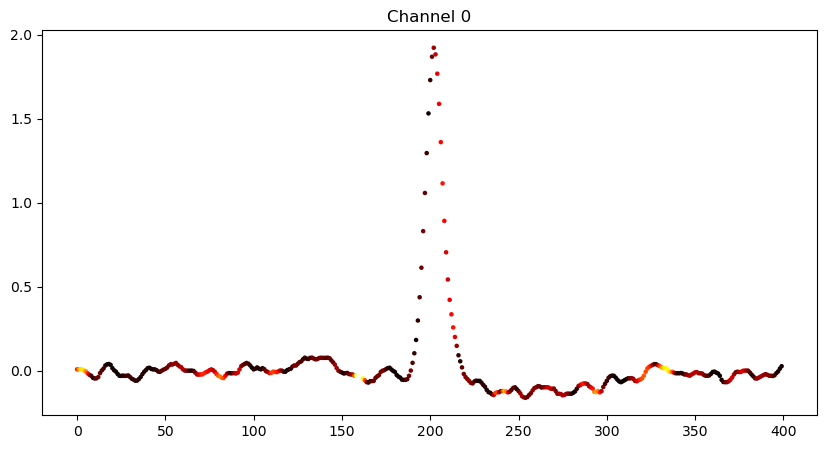

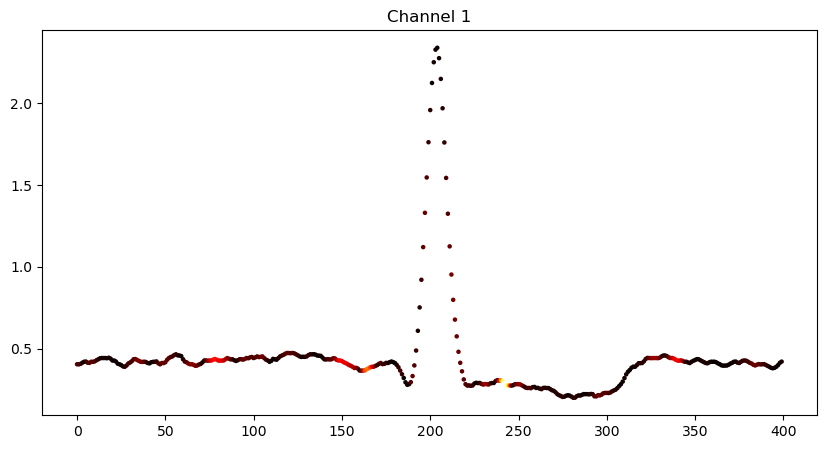

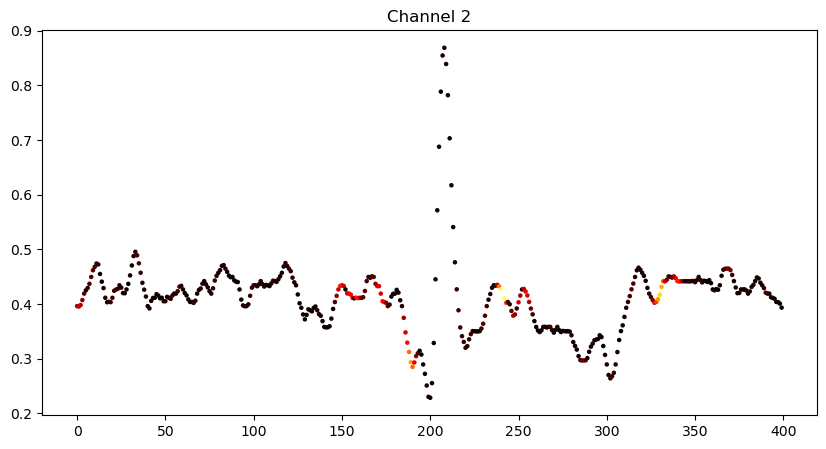

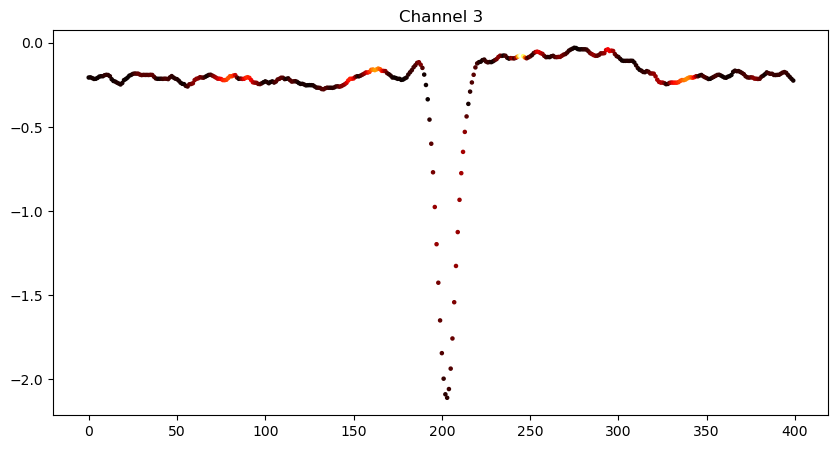

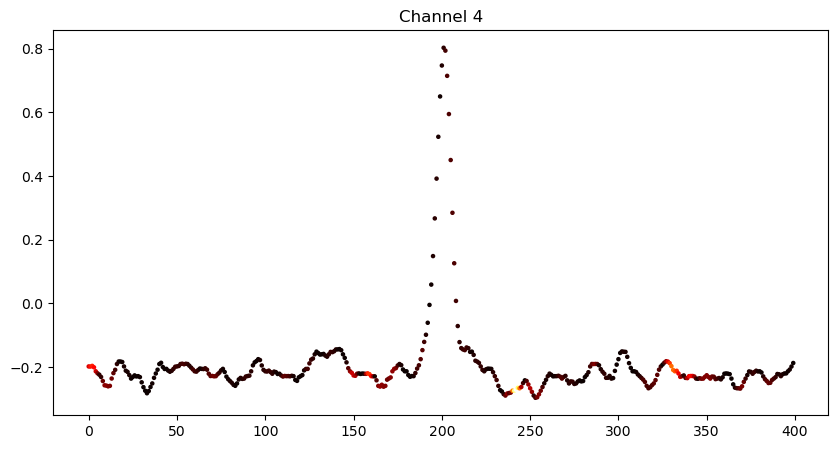

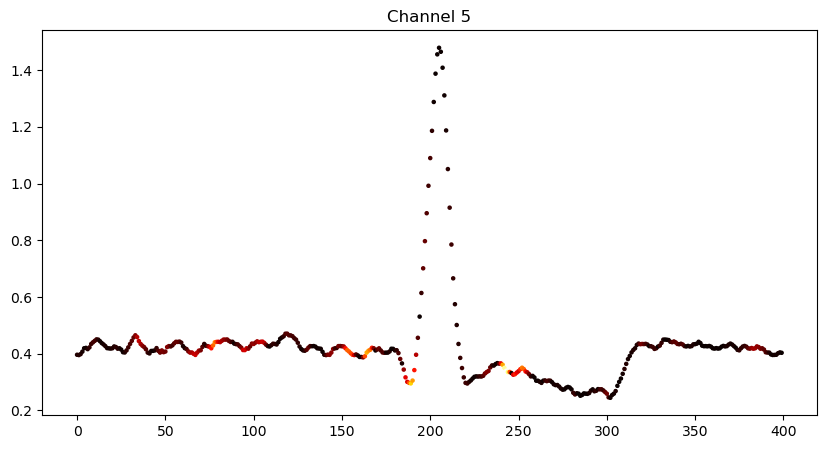

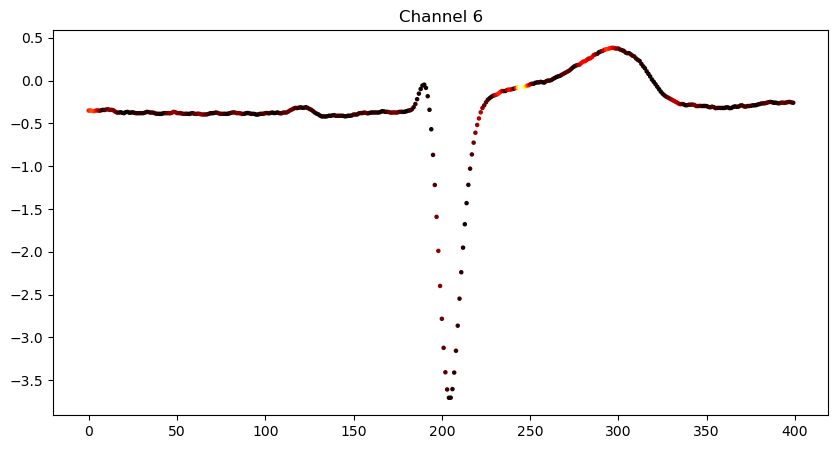

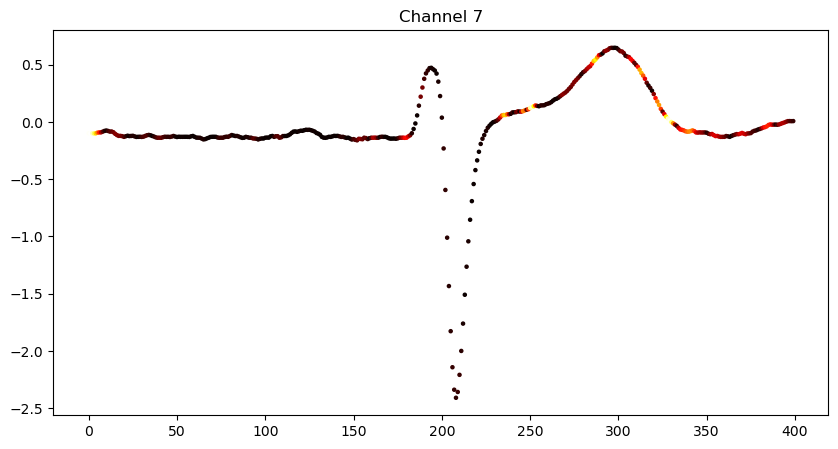

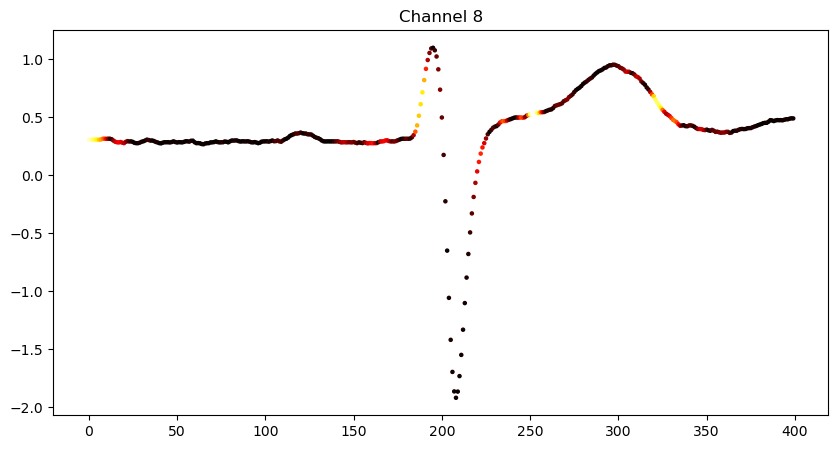

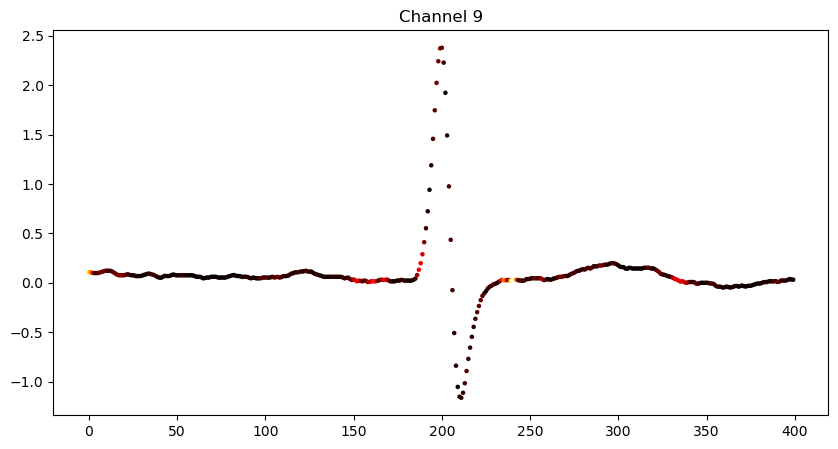

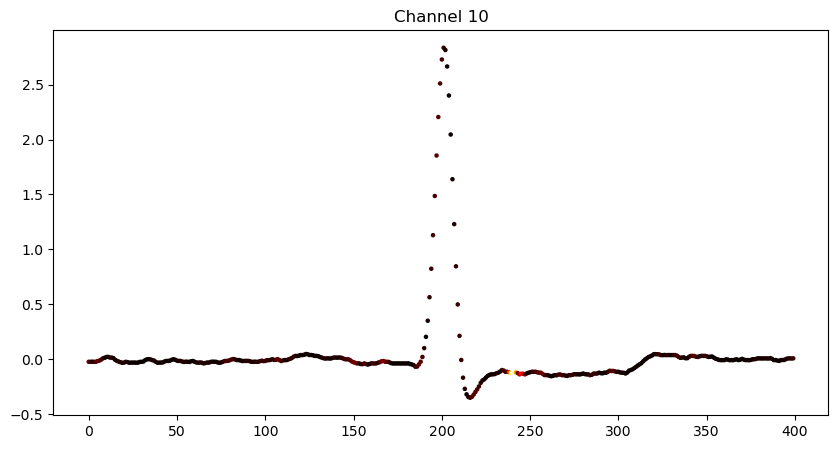

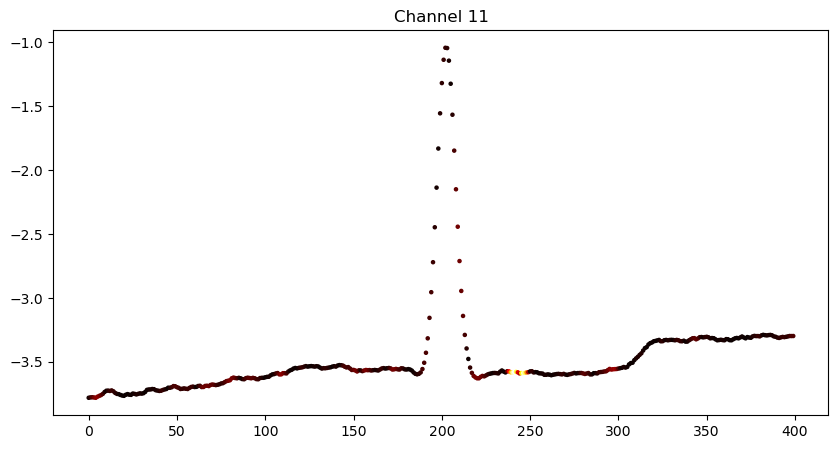

In [7]:
for chan in range(12):
    colors = np.abs(plot_array[0, chan, 1800:2200])
    colors = colors / max(colors)
    plt.figure(figsize=(10, 5))
    plt.scatter(np.arange(400), data_array[0, 1800:2200, chan], 
                color=cm.hot(colors),
                s=5)
    plt.title(f"Channel {chan}")
    plt.show()

In [8]:
# this array contains one beat for each subject and channel.
one_beat = np.load("../data/one_beat_array.npy")
one_beat.shape

(6044, 4096, 12)

In [9]:
pred_zero_fill = predict(one_beat)

In [10]:
n_subjects = one_beat.shape[0]
attributions_ig = np.zeros([n_subjects, one_beat.shape[2], one_beat.shape[1]])
for subject in range(n_subjects):
    if subject % 100 == 0:
        print(subject)
    input = torch.tensor(one_beat).float().transpose(-1, -2)[subject, :, :].unsqueeze(0)
    attributions_ig[subject, :, :] = integrated_gradients.attribute(input).numpy()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


In [11]:
attributions_avg = attributions_ig.mean(axis=0)

one_beat_avg = one_beat.mean(axis=0)

print(attributions_avg.shape, one_beat_avg.shape)

(12, 4096) (4096, 12)


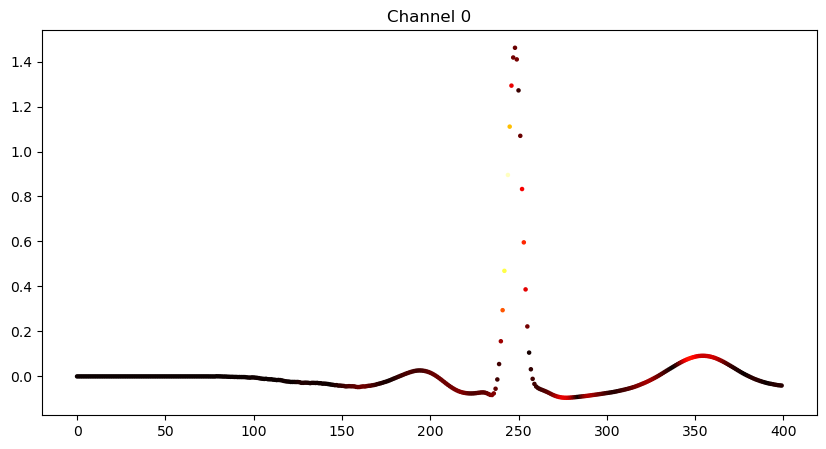

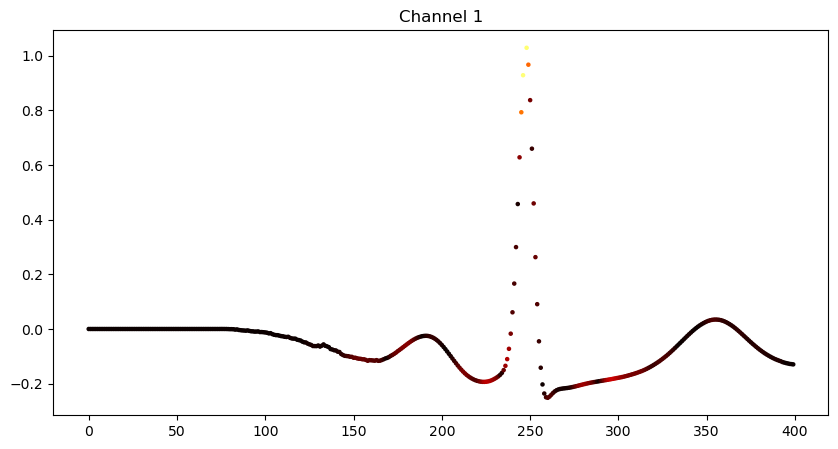

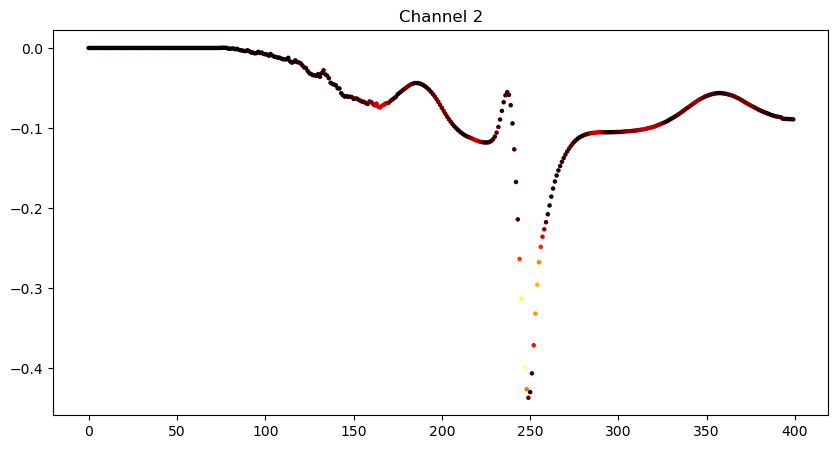

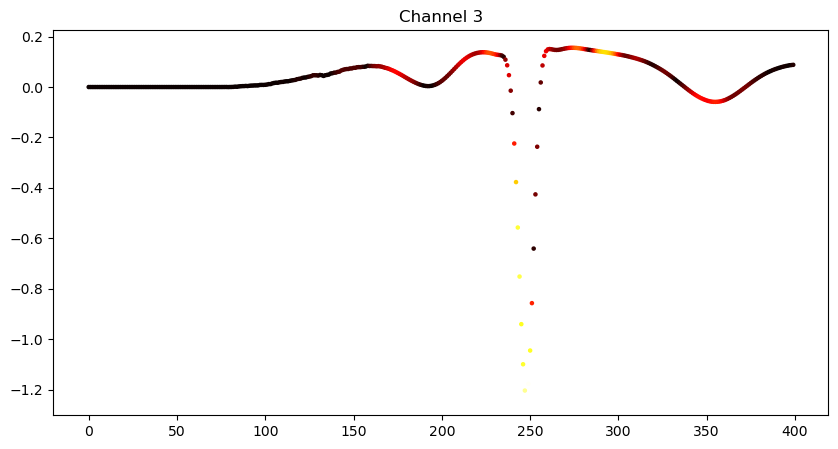

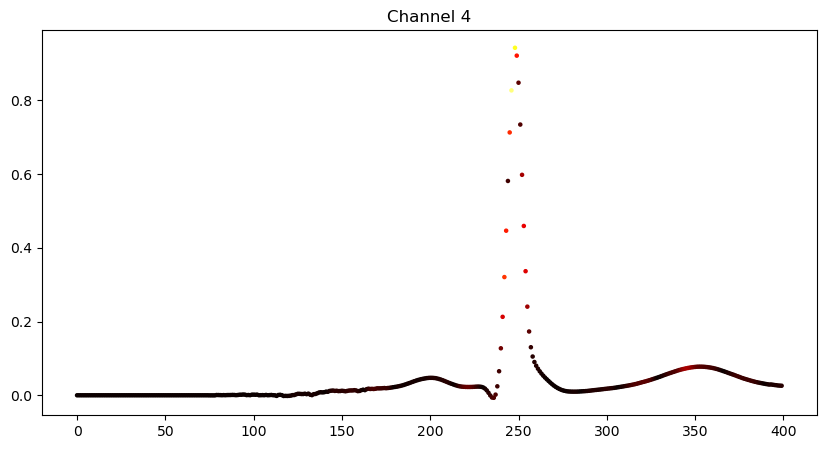

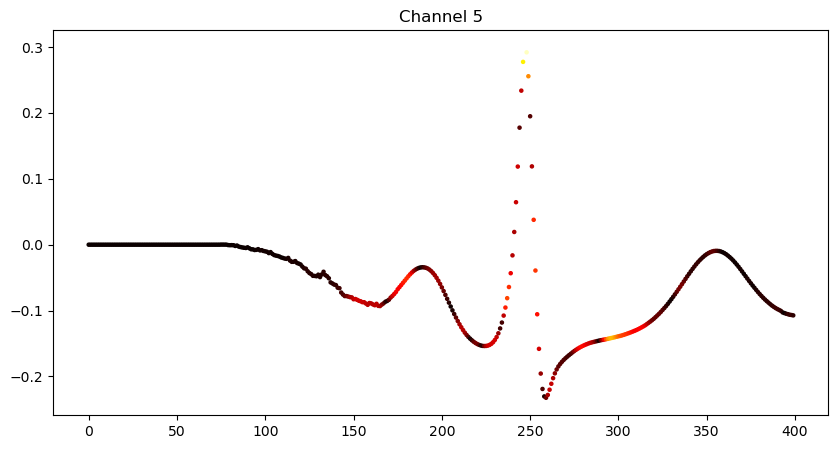

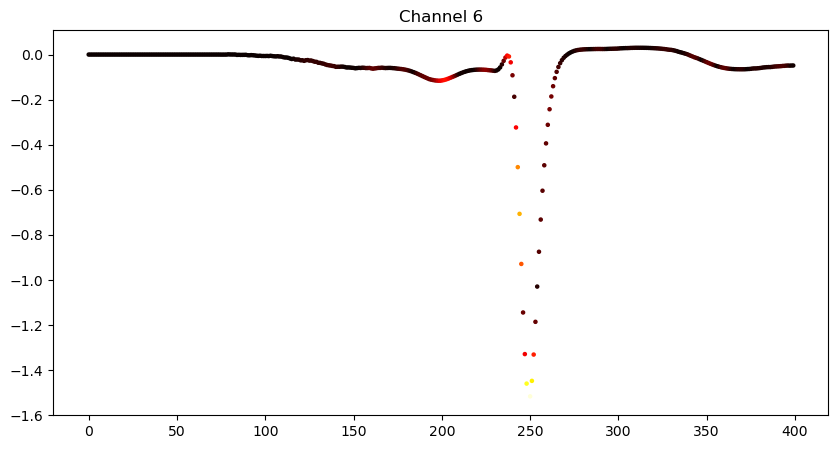

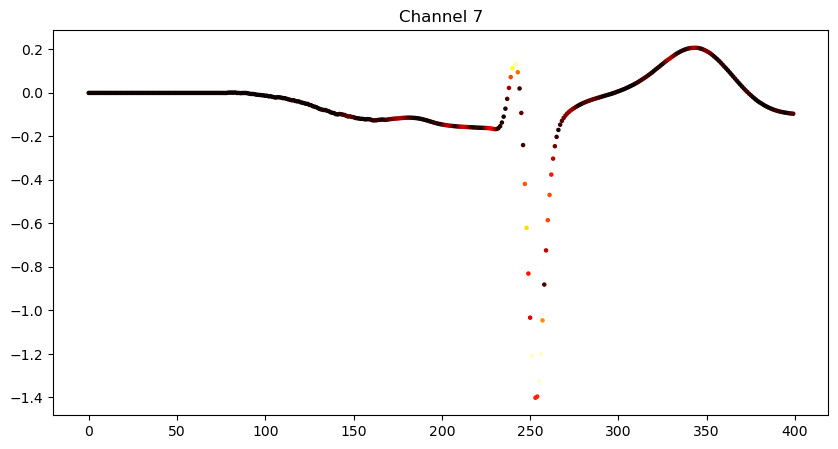

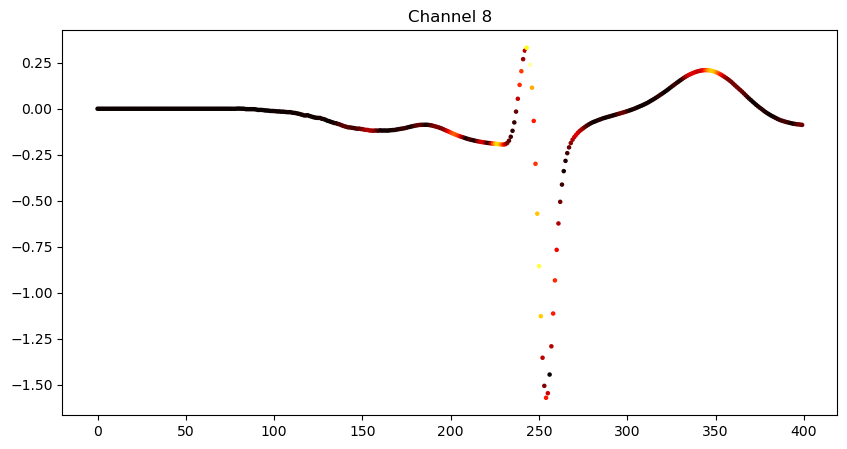

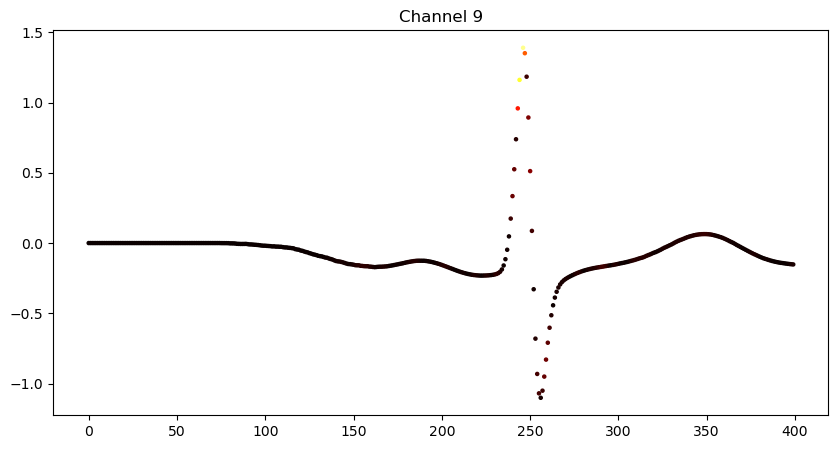

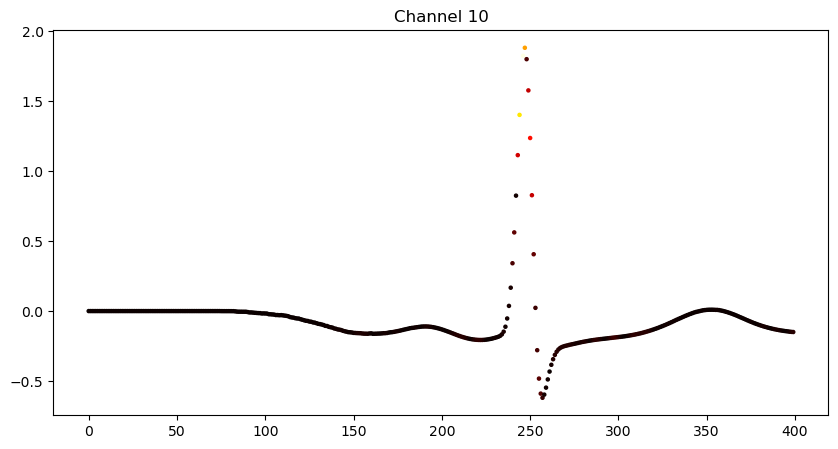

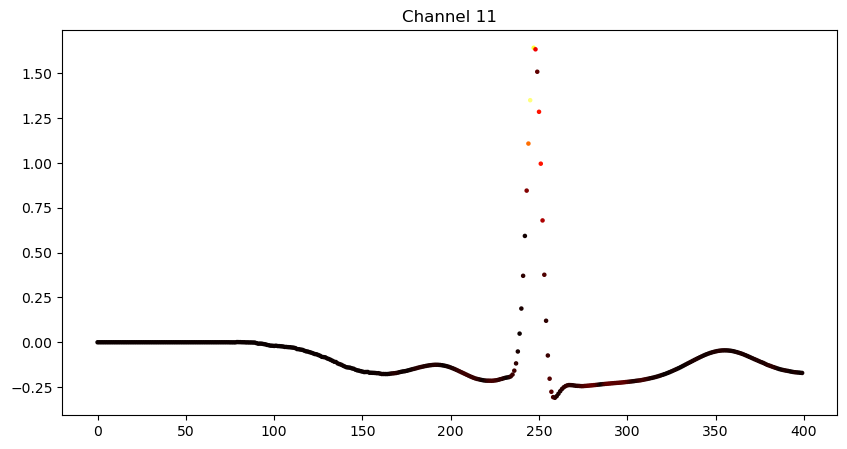

In [12]:
for chan in range(12):
    colors = np.abs(attributions_avg[chan, 1800:2200])
    colors = colors / max(colors)
    plt.figure(figsize=(10, 5))
    plt.scatter(np.arange(400), one_beat_avg[1800:2200, chan], 
                color=cm.hot(colors),
                s=5)
    plt.title(f"Channel {chan}")
    plt.show()